## Calculate the TWA transport tensor

Here we take the time averaged TWA fields (means and eddy fluxes) and estimate the corresponding transport tensor. 

Here we use a coarsening scale of 50km since it worked well with the Z-averaged fields. 

In [1]:
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt

import xgcm 
%matplotlib inline

import numpy as np
from xgcm import Grid
from scipy.linalg import pinv, eig
from numpy.linalg import eigh

In [2]:
# load the grid for taking horizontal gradients
ds = xr.open_zarr('/swot/SUM04/dbalwada/channel_model/05km_sponge/run_tracers_restored_3day_output/run_tracers_restored_zarr/')
grid = Grid(ds, periodic='X')

In [3]:
ds_hat = xr.open_dataset('analysis_data_files/ds_hat_800.nc')

# these eddy fluxes were saved as uppcpp 
ds_eddy_u = xr.open_dataset('analysis_data_files/ds_twa_eddy_u_800.nc')
ds_eddy_v = xr.open_dataset('analysis_data_files/ds_twa_eddy_v_800.nc')

In [4]:
# the x and y gradients of hat mean
ds_hat_grads = xr.Dataset()
 
dx = 5e3

for var_name in ds_hat.keys():
    if (var_name != 'U' and var_name != 'V'):
        ds_hat_grads['d'+var_name+'dx'] = grid.interp(grid.diff(ds_hat[var_name], 'X')/dx, 'X')
        
        ds_hat_grads['d'+var_name+'dy'] = grid.interp(grid.diff(ds_hat[var_name], 'Y', boundary='extend')/dx,
                                                      'Y', boundary='extend')
        

In [5]:
# copied and modified from funcs.py
def get_flux_arrays_2D(ds_u, ds_v, list_tracers): 
    # U''C''
    testxr1 = ds_u['U_'+'PTRACER01']
    testxr1['tracer_num'] = 1

    UppCpp = testxr1 

    n=2
    for i in list_tracers[1:]: 
        temp = ds_u['U_'+i]
        temp['tracer_num'] = n 
        n=n+1

        UppCpp = xr.concat([UppCpp, temp], dim='tracer_num')

    UppCpp.name = 'UppCpp'
    
    # V''C''
    testxr1 = ds_v['V_'+'PTRACER01']
    testxr1['tracer_num'] = 1

    VppCpp = testxr1 

    n=2
    for i in list_tracers[1:]: 
        temp = ds_v['V_'+i]
        temp['tracer_num'] = n 
        n=n+1

        VppCpp = xr.concat([VppCpp, temp], dim='tracer_num')

    VppCpp.name = 'VppCpp'
    
    return [UppCpp, VppCpp]

In [6]:
list_tracers = ['PTRACER01', 'PTRACER02', 'PTRACER03', 'PTRACER04', 'PTRACER05',
               'PTRACER06', 'PTRACER07', 'PTRACER08', 'PTRACER09', 'PTRACER10',
               'PTRACER11', 'PTRACER12', 'PTRACER13', 'PTRACER14', 'PTRACER15',
               'PTRACER16', 'PTRACER17', 'PTRACER18', 'PTRACER19', 'PTRACER20']

In [7]:
[UppCpp, VppCpp] = get_flux_arrays_2D(ds_eddy_u, ds_eddy_v, list_tracers)

In [8]:
def get_grad_arrays_2D(ds, list_tracers): 
    # Put tracer gradients into xarrays
    
    # dCdx
    testxr1 = ds['dPTRACER01dx']
    testxr1['tracer_num'] = 1

    dCdx = testxr1 

    n=2
    for i in list_tracers[1:]: 
        temp = ds['d'+i+'dx']
        temp['tracer_num'] = n 
        n=n+1

        dCdx = xr.concat([dCdx, temp], dim='tracer_num')   
    dCdx.name = 'dCdx'
    
    # dCdy
    testxr1 = ds['dPTRACER01dy']
    testxr1['tracer_num'] = 1

    dCdy = testxr1 

    n=2
    for i in list_tracers[1:]: 
        temp = ds['d'+i+'dy']
        temp['tracer_num'] = n 
        n=n+1

        dCdy = xr.concat([dCdy, temp], dim='tracer_num')
    dCdy.name = 'dCdy'
    
    return [dCdx, dCdy]

In [9]:
[dCdx, dCdy]= get_grad_arrays_2D(ds_hat_grads, list_tracers)

In [10]:
# coarsen fields 
#npts = int(50e3/dx)
#UppCpp_coarse = UppCpp.coarsen(XC=npts, YC=npts).mean().rename('UppCpp')
#VppCpp_coarse = VppCpp.coarsen(XC=npts, YC=npts).mean().rename('VppCpp')
#dCdx_coarse = dCdx.coarsen(XC=npts, YC=npts).mean().rename('dCdx')
#dCdy_coarse = dCdy.coarsen(XC=npts, YC=npts).mean().rename('dCdy')

In [11]:
#UppCpp_coarse.to_netcdf('analysis_data_files/UppCpp_TWA_50km_av800.nc')
#VppCpp_coarse.to_netcdf('analysis_data_files/VppCpp_TWA_50km_av800.nc')
#dCdx_coarse.to_netcdf('analysis_data_files/dCdx_TWA_50km_av800.nc')
#dCdy_coarse.to_netcdf('analysis_data_files/dCdy_TWA_50km_av800.nc')

In [10]:
def calc_tensor_2D(uc,vc, cx,cy):
    Aflux = np.array([uc, vc])
    Agrad = np.array([cx, cy])

    if ~(np.isnan(Agrad).any() | np.isnan(Aflux).any()):
        return -(Aflux.dot(pinv(Agrad)))
    else:
        return np.nan*(Aflux.dot(Agrad.T))  

### Actually compute the tensor

In [12]:
%%time
Ktensor_fast = xr.apply_ufunc(calc_tensor_2D, 
                       UppCpp.sel(tracer_num=slice(1,19,2)),
                       VppCpp.sel(tracer_num=slice(1,19,2)),
                       dCdx.sel(tracer_num=slice(1,19,2)),
                       dCdy.sel(tracer_num=slice(1,19,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':2,'j':2})
Ktensor_fast.load();

/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/ipykernel/__main__.py:8: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


CPU times: user 23min 5s, sys: 383 ms, total: 23min 6s
Wall time: 23min 6s


<xarray.DataArray (YC: 400, XC: 400, T: 101, i: 2, j: 2)>
array([[[[[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         ...,

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]]],

...

        [[[ 7.23714355e+03,  2.98789093e+02],
          [ 3.04647736e+02,  1.53877687e+01]],

         [[ 9.62121484e+03,  3.65194946e+02],
          [ 3.42119049e+02,  1.01283827e+01]],

         [[ 1.47279229e+04,  1.71813232e+02],
          [ 1.17653801e+02,  6.54271555e+00]],

         ...,

         [[ 1.09099277e+04, -2.54142654e+02],
          [-9.89370422e+01,  6.37863219e-01]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]]]]], dtype=float32)
Coordinates:
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 2.985e+03 2.985e+03 2.985e+03
  * XC       (XC) float32 2.5e+03 7.5e+03 1.25e+04 ... 1.992e+06 1.998e+06
  * YC       (YC) float32 2.5e+03 7.5e+03 1.25e+04 ... 1.992e+06 1.998e+06
    rA       (YC, XC) float32 2.5e+07 2.5e+07 2.5e+07 ... 2.5e+07 2.5e+07
  * T        (T) float64 0.0 0.08 0.16 0.24 0.32 0.4 ... 7.68 7.76 7.84 7.92 8.0
Dimensions without coordinates: i, j

In [13]:
%%time
Ktensor_slow = xr.apply_ufunc(calc_tensor_2D, 
                       UppCpp.sel(tracer_num=slice(2,20,2)),
                       VppCpp.sel(tracer_num=slice(2,20,2)),
                       dCdx.sel(tracer_num=slice(2,20,2)),
                       dCdy.sel(tracer_num=slice(2,20,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':2,'j':2})

Ktensor_slow.load();

/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/ipykernel/__main__.py:8: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


CPU times: user 23min 20s, sys: 4.1 s, total: 23min 24s
Wall time: 23min 24s


<xarray.DataArray (YC: 400, XC: 400, T: 101, i: 2, j: 2)>
array([[[[[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         ...,

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]]],

...

        [[[ 6.96320215e+03,  3.81932129e+02],
          [ 2.30084381e+02,  2.59801998e+01]],

         [[ 1.15577822e+04,  1.04583122e+02],
          [ 3.63893433e+02,  6.56921339e+00]],

         [[ 1.40569424e+04, -9.67632446e+01],
          [ 1.01428665e+02,  2.14256668e+00]],

         ...,

         [[ 1.05121553e+04, -3.35576416e+02],
          [-9.07858505e+01,  1.81187689e+00]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]]]]], dtype=float32)
Coordinates:
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 2.985e+03 2.985e+03 2.985e+03
  * XC       (XC) float32 2.5e+03 7.5e+03 1.25e+04 ... 1.992e+06 1.998e+06
  * YC       (YC) float32 2.5e+03 7.5e+03 1.25e+04 ... 1.992e+06 1.998e+06
    rA       (YC, XC) float32 2.5e+07 2.5e+07 2.5e+07 ... 2.5e+07 2.5e+07
  * T        (T) float64 0.0 0.08 0.16 0.24 0.32 0.4 ... 7.68 7.76 7.84 7.92 8.0
Dimensions without coordinates: i, j

In [14]:
lam1 = 1/31104000. # hard code the restoring times
lam2 = 1/186624000.

Ktensor_corr = (lam2*Ktensor_fast - lam1*Ktensor_slow)/(lam2 - lam1)

In [15]:
Ktensor_corrT = Ktensor_corr.transpose('YC','XC','T','j','i')

STcorr = 0.5*(Ktensor_corr.data + Ktensor_corrT.data)
ATcorr = 0.5*(Ktensor_corr.data - Ktensor_corrT.data)

STcorr= xr.DataArray(STcorr, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)
ATcorr = xr.DataArray(ATcorr, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)

In [16]:
# make sure the eigen values are arranged by magnitude (instead of the default arrangement)
def eigen(A):
 #   if ~np.isnan(A[0,0]):
    if np.isnan(A).any(): A = np.nan_to_num(A)
    eigenValues, eigenVectors = eigh(A)
    idx = np.argsort(np.abs(eigenValues))
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]

        
    return (eigenValues, eigenVectors)

In [17]:
# calculate the eigenvalues and eigenvectors of symmetric part
eigvalsSTcorr, eigvecsSTcorr = xr.apply_ufunc(eigen, STcorr, input_core_dims=[['i','j']],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])

In [18]:
diff_tensor = xr.Dataset()
diff_tensor['Kfast'] = Ktensor_fast
diff_tensor['Kslow'] = Ktensor_slow
diff_tensor['Kcorr'] = Ktensor_corr
diff_tensor['STcorr'] = STcorr
diff_tensor['ATcorr'] = ATcorr
diff_tensor['eigvalsSTcorr'] = eigvalsSTcorr
diff_tensor['eigvecsSTcorr'] = eigvecsSTcorr


In [19]:
diff_tensor.to_netcdf('analysis_data_files/diff_tensor_TWA_av800.nc')

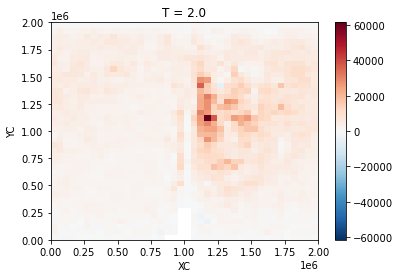

In [23]:
Ktensor_fast.isel(i=1, j=1).sel(T=2, method='nearest').plot()